# DASC 512 - 19 - One-Sample Tests of Central Tendency

***

This lesson introduces the one-sample z-test, t-test, Wilcoxon signed rank test, and the binomial test.

* The t test is used when the parameter of interest is the mean.
* The Wilcoxon signed rank test is used when the parameter of interest is the median, or when the distribution and sample size do not support an assumption of population normality or invocation of the Central Limit Thoerem.
* The binomial test is used when the parameter of interest is the proportion.

***

In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.graphics.api as smg

sns.set_style('whitegrid')

## *z*-test: The simple case for educational purposes

The *z*-test is still taught primarily for legacy and educational purposes. There is rarely a real-world reason to use this unless you're stuck in a vault with only a textbook as support (even Excel will implement a *t*-distribution).

### Example: Mean political ideology (GSS)

First, let's create the DataFrame for the given data. One way to do this...

In [3]:
ideology = [1,2,3,4,5,6,7]
hispanic = [5,49,46,155,50,50,14]
black = [16,52,42,182,43,25,11]
white = [73,209,190,705,260,314,84]
gss = pd.DataFrame({'Ideology':ideology,
                   'Hispanic':hispanic,
                   'Black':black,
                   'White':white})

In [4]:
gss

,Ideology,Hispanic,Black,White
0,1,5,16,73
1,2,49,52,209
2,3,46,42,190
3,4,155,182,705
4,5,50,43,260
5,6,50,25,314
6,7,14,11,84


This data format should immediately jump out as not being a data matrix. It is going to be a **bear** to work with.

In [6]:
# Mean
gss_race = 'Hispanic'
gss_mean = np.sum(np.multiply(gss['Ideology'], gss[gss_race])) / gss[gss_race].sum()
gss_mean

4.0894308943089435

Gross, right? This is a learning moment. Embrace the data matrix, even when it's longer, if you can!

In [18]:
race = []
ideo = []
for ii in ideology:
    hisp = hispanic[ii-1]
    bla = black[ii-1]
    whi = white[ii-1]
    race += ['Hispanic'] * hisp
    race += ['Black'] * bla
    race += ['White'] * whi
    ideo += [ii] * (hisp + bla + whi)
gss = pd.DataFrame({'Race':race, 'Ideology':ideo})

In [20]:
gss.value_counts()

Race      Ideology
White     4           705
          6           314
          5           260
          2           209
          3           190
Black     4           182
Hispanic  4           155
White     7            84
          1            73
Black     2            52
Hispanic  5            50
          6            50
          2            49
          3            46
Black     5            43
          3            42
          6            25
          1            16
Hispanic  7            14
Black     7            11
Hispanic  1             5
dtype: int64

Ok! Now, recall the research question:

*Are Hispanic Americans on average moderate?*

This gives:
* Null hypothesis: mu = 4
* Alternative hypothesis: mu != 4

The parameter of interest is the mean. We will assume ideologies are normally distributed.

In [29]:
gss_hisp = gss[gss['Race'] == 'Hispanic']['Ideology']

<AxesSubplot:ylabel='Frequency'>

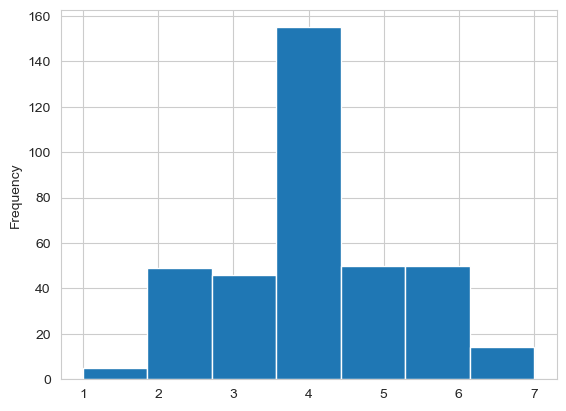

In [30]:
gss_hisp.plot(kind='hist', bins=7)

In [31]:
gss_hisp.describe()

count    369.000000
mean       4.089431
std        1.339258
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        7.000000
Name: Ideology, dtype: float64

In [38]:
# Critical value (rejection region)
zcrit = stats.norm.isf(0.05/2)
zcrit

1.9599639845400545

In [34]:
# Point estimate
xbar = gss_hisp.mean()
xbar

4.0894308943089435

In [35]:
# Standard error
sem = gss_hisp.std() / np.sqrt(len(gss_hisp))
sem

0.06971896384894542

In [36]:
# Test statistic
z = (xbar - 4.0) / sem
z

1.2827341281592528

Conclusion: There is insufficient evidence to conclude that the mean ideology of Hispanic Americans is not moderate (4).

In [39]:
# p-value
pval = 2 * stats.norm.sf(abs(z))
pval

0.19958523893184177

In [40]:
# Confidence interval
ci = stats.norm(loc=xbar, scale=sem).interval(0.95)
ci

(3.9527842361255603, 4.226077552492327)

## *t*-test: One-sample test about means

While the *z*-test isn't implemented in Python directly, other tests are!

In [42]:
a = gss_hisp  # a is the relevant column of data
popmean = 4.0  # popmean is the hypothesized mean (H0)
alternative = 'two-sided'  # may be 'greater', 'less', or 'two-sided'

t, pval = stats.ttest_1samp(a=a, popmean=popmean, alternative=alternative)
print(f'The test statistic was t={t:.2f} and the p-value was p={pval:.2f}')

The test statistic was t=1.28 and the p-value was p=0.20


To calculate the confidence interval, use the .interval function (or ppf/isf).

In [44]:
ci = stats.t(df=len(gss_hisp)-1, loc=xbar, scale=sem).interval(0.95)
ci

(3.9523333438891632, 4.226528444728724)

## Wilcoxon Signed Rank Sum test: One-sample non-parametric test about medians

This test can be used when other tests seem inappropriate, likely due to non-normal population data and small sample sizes. 

Recall the example of a rifle marksman. 

In [49]:
distances = [-1.1, 1.9, -0.6, 1.6, -1.2, -3.2, -3.4, -1.9]
theta0 = 0  # Hypothesized median (H0)
di = np.subtract(distances, theta0)  # Differences (test is against 0)
alternative = 'two-sided'
mode = 'exact'  # Default is "auto" which uses normal approximation for n>25

In [50]:
W, pval = stats.wilcoxon(di, alternative=alternative, mode=mode)
print(f'The test statistic is {W} and the p-value is {pval:.3f}')

The test statistic is 9.5 and the p-value is 0.250


## Binomial test: One-sample test about proportions

Suppose two chess players face off in a tournament in 5 games. Player 1 beats Player 2 in all 5 games. Is Player 1 better than Player 2?

Hypothesis:
* Null: p=0.5
* Alternative: p>0.5

In [45]:
x = 5  # Number of successes
n = 5  # Number of trials
p = 0.5  # Hypothesized proportion (H0)
alternative = 'greater'  # may be 'greater', 'less', or 'two-sided'

pval = stats.binom_test(x=x, n=n, p=p, alternative=alternative)
pval

0.03125

Yes, we can say with 95% confidence that Player 1 is better than Player 2.

Could we say that Player 1 and Player 2 are not evenly matched?

In [46]:
pval = stats.binom_test(x=x, n=n, p=p, alternative='two-sided')
pval

0.0625

No, we cannot say with 95% confidence that Player 1 and Player 2 are not evenly matched. Ironically, the same data allows us to conclude Player 1 is better. This is the importance of picking your hypotheses prior to analyzing data!

# That's all for this lesson!